### Tests
Use of the agglomerative clustering with HR diagram.

We test here dbscan parameters to detect good solutions for clustering

In [28]:
import sys, os
sys.path.append('../../src')

from numba import jit

import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import pickle

from math import ceil
import math
import gaia_utils as gu
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from astroML.correlation import two_point
from astroML.correlation import bootstrap_two_point_angular

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 14, 6
###################################

clustername = "NGC 1647"
clustername = 'Basel 11B'
clustername = 'NGC 1980'
# clustername = 'NGC 2143'
# voname = 'NGC 752-1.0deg.vot'
voname = 'NGC 2682-3.0deg.vot'
# voname = "Ruprecht 1-2.0deg.vot"

RADIUS   = 3.0
votable_disk = False
distclust = 572.0
WEIGHT = [6.5, 6.5, 10.7, 4.1, 4.1, 2.1, 2.1, 2.1]


In [29]:
## plot2D and plot3D


def plot2d(df, labels, ilab, cmap = "gist_stern" ,color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c = "k")
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-0.5,2.0)
    axarr[1,1].set_ylim(27.,10)
    
    plt.show()
    

In [30]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

### Metrics

Metric to quantify goodness-of-solution for the clustering.

In [31]:
def metric1(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP =20 ):
    "Using the density contrat assuming the OC is at the center"
    
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        Q_c = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            dens_out_k = max(1,len(nout)) / aper2
            Q_c[k] = dens_clust / dens_out_k
            
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)
                          
    
def metric2(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP = 50 , SIGCLIP = 0.):
    "Using the density contrat assuming the OC is at the center and the distribution around is regular (no holes)"
        
    epsilon = 0.1
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        nstarsout = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            nstarsout[k] = len(nout) + np.random.uniform(1., 1.+ epsilon)
                
        outmean = np.mean(nstarsout)
        outstd  = np.std(nstarsout)
        
        nstar_filtered = np.where( (nstarsout - outmean)/ outstd > SIGCLIP )

        dens_out = nstarsout[nstar_filtered] / aper2
        Q_c = np.zeros(len(dens_out))
        Q_c = dens_clust / dens_out
        
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric) 

def metric2_label(df, labels, ilab, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP = 50 , SIGCLIP = 0.):
    "Using the density contrat assuming the OC is at the center and the distribution around is regular (no holes)"
        
    epsilon = 0.1
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    
    dflab = df[np.where(labels == ilab),:][0]
    radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
    nclust = radii[np.where(radii < aper2)]
    dens_clust = len(nclust) / aper2
        
    angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
    rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
    nstarsout = np.zeros(NBOOTSTRAP)
        
    for k in range(NBOOTSTRAP): 
        xi = xc + rad_out[k]*math.cos(angle_out[k])
        yi = yc + rad_out[k]*math.sin(angle_out[k])
        radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
        nout = radii_out[np.where(radii_out < aper2)]
        nstarsout[k] = len(nout) + np.random.uniform(1., 1.+ epsilon)
                
    outmean = np.mean(nstarsout)
    outstd  = np.std(nstarsout)
        
    nstar_filtered = np.where( (nstarsout - outmean)/ outstd > SIGCLIP )

    dens_out = nstarsout[nstar_filtered] / aper2
    Q_c = np.zeros(len(dens_out))
    Q_c = dens_clust / dens_out
        
    Q = np.mean(Q_c)
    Q_err = np.std(Q_c)
        
    return(Q, Q_err) 


def dbscan_(dfnorm_gaia, df_gaia, eps, min_samples, FILTER = False):
    "dbscan clustering with analysis of the clusters and filtering"
    
    dbscan = cluster.DBSCAN(eps = eps, min_samples = min_samples)
    dbscan.fit(dfnorm_gaia)
    labels_d = dbscan.labels_
    unique_labels = set(labels_d)
    n_clusters_ = len(set(labels_d)) - (1 if -1 in labels_d else 0)
        
    result = {}
    result['label'] = []
    result['nstars'] = []
    result['distance'] = []
    result['distance_std'] = []    
    result['pos'] = []
    result['pos_std'] = []
    result['vel'] = []
    result['vel_std'] = []
    
    for i in range(-1,n_clusters_):
        result['label'].append(i)
        result['nstars'].append(len(labels_d[np.where(labels_d == i)]))
        result['distance'].append(np.median(df_gaia[np.where(labels_d == i),2]))
        result['distance_std'].append(np.std(df_gaia[np.where(labels_d == i),2]))
        result['pos'].append([np.median(df_gaia[np.where(labels_d == i),0]), np.median(df_gaia[np.where(labels_d == i),1])])
        result['pos_std'].append([np.std(df_gaia[np.where(labels_d == i),0]), np.std(df_gaia[np.where(labels_d == i),1])])
        result['vel'].append([np.median(df_gaia[np.where(labels_d == i),3]), np.median(df_gaia[np.where(labels_d == i),4])])
        result['vel_std'].append([np.std(df_gaia[np.where(labels_d == i),3]), np.std(df_gaia[np.where(labels_d == i),4])])         

    return(labels_d, result)

In [32]:
def iter_dbscan(epsmin, epsmax, sample_min, sample_max, neps = 20, aper = 0.5, 
                qmin = 7., TEST_NSTAR = True, von = "test.vot", verbose = True):
    "Range of the parameters for dbscan. The selection can be done either on Q or nstar and Q..."
        
        
    if TEST_NSTAR:
        print("## DBSCAN selection of the clusters with  Q > %f and the maximum of stars."%(qmin))
    else:
        print("## DBSCAN selection of the clusters with  Q maximum regardless of the number of stars.")
        
    s = gu.source(clustername)
    s.read_votable(von)
    s.weight = WEIGHT
    s.convert_filter_data(mag_range = [0., 40])
    s.normalization_normal()

    metric = {}

    epsilon    = np.linspace(epsmin,epsmax, neps)
    sample_min = np.arange(sample_min, sample_max)
    
    metric['eps'] = []
    metric['min_samples'] = []
    metric['Q'] = []
             
    qmax = 0.
    nstar_max = 0
    cluster_best = {}
    label_best = []
    ilab_best = []
    
    epsilon_best = 0
    min_sample_best = 0
    ilab_best = -1
    
    for e in epsilon:
        print('.' , end="")
        for sm in sample_min:
                
                labels_d, result = dbscan_(s.dfnorm, s.df, e, sm, FILTER = False)
                n_clusters_ = len(result['label']) -1
                
                if n_clusters_ > 0:
                    for nstar, lab in zip(result['nstars'], result['label']):
                        
                        if lab > -1:
                            Q, Q_err = metric2_label(s.df, labels_d, lab,  APERTURE = aper , MAXRADIUS = 0.9 * RADIUS , NBOOTSTRAP =50 )
                        else:
                            Q, Q_err = 0. , 0.
                            
                        ## SELECTION .... ########################
                        if TEST_NSTAR:
                            if Q > qmin and nstar > nstar_max:
                                cluster_best = result
                                label_best = labels_d
                                ilab_best = lab
                                epsilon_best = e
                                min_sample_best = sm
                                qmax = Q
                                nstar_max = nstar
                        else:
                            if Q > qmax:
                                cluster_best = result
                                label_best = labels_d
                                ilab_best = lab
                                epsilon_best = e
                                min_sample_best = sm
                                qmax = Q
                                nstar_max = nstar
                            
                    
                    if verbose:
                        print("##")
                        print("Epsilon: %3.2f - Min Sample: %d"%(e,sm))
                        for i in range(max(labels_d)+1):
                            print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
                            print("##")
                else:
                    metric['Q'].append(0.)
                    metric['eps'].append(e)
                    metric['min_samples'].append(sm)
                            
    print("\n## DBSCAN done!") 
    print("Eps: %f - min sample: %d"%(epsilon_best, min_sample_best))
    print("Q max: %f"%(qmax))
    print(cluster_best)
    
    return(label_best, ilab_best, cluster_best, epsilon_best, min_sample_best)

In [33]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
# voname = source.query(RADIUS, coor = [10.0, -10.0] , errtol = 0.2, dump = True)
source.read_votable(voname)
source.convert_filter_data(mag_range = [0., 40])
source.normalization_normal()
#source.normalization_minmax()

## NGC 2682-3.0deg.vot read...
## Total stars: 35533
## Conversion done...
## Stars selected: 32683
## Normalization Normal-Gauss done on filtered data..


()

### Clustering

In [34]:
labels_ , ilab_ , cluster_ , eps_, min_sample_  = iter_dbscan(0.1, 5., 5,50, neps = 20, 
                                                              aper = 0.5, qmin = 7., TEST_NSTAR = False, von = voname, verbose = False)

## DBSCAN selection of the clusters with  Q > 7.000000 and the maximum of stars.
## NGC 2682-3.0deg.vot read...
## Total stars: 35533
## Conversion done...
## Stars selected: 32683
## Normalization Normal-Gauss done on filtered data..
....................
## DBSCAN done!
Eps: 3.194737 - min sample: 24
Q max: 8.637750
{'label': [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'nstars': [29584, 39, 25, 28, 217, 25, 13, 95, 91, 1904, 390, 24, 50, 40, 34, 21, 20, 24, 59], 'distance': [811.306548214302, 485.3172782775645, 1222.5899236916507, 416.06840833836634, 383.8861519250621, 537.4706746367872, 512.3977539002193, 367.6480606165363, 1328.1502391496988, 864.0092545244588, 409.11448636677324, 1350.9837540924323, 254.05430684344225, 347.015854147681, 409.1551284625298, 414.0215363563169, 397.0692724579663, 1212.6596560292164, 442.54977843608265], 'distance_std': [473.64147997664804, 42.10630632283185, 44.32084793929715, 42.33938431894521, 68.81102676190638, 45.93277245662

8
[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


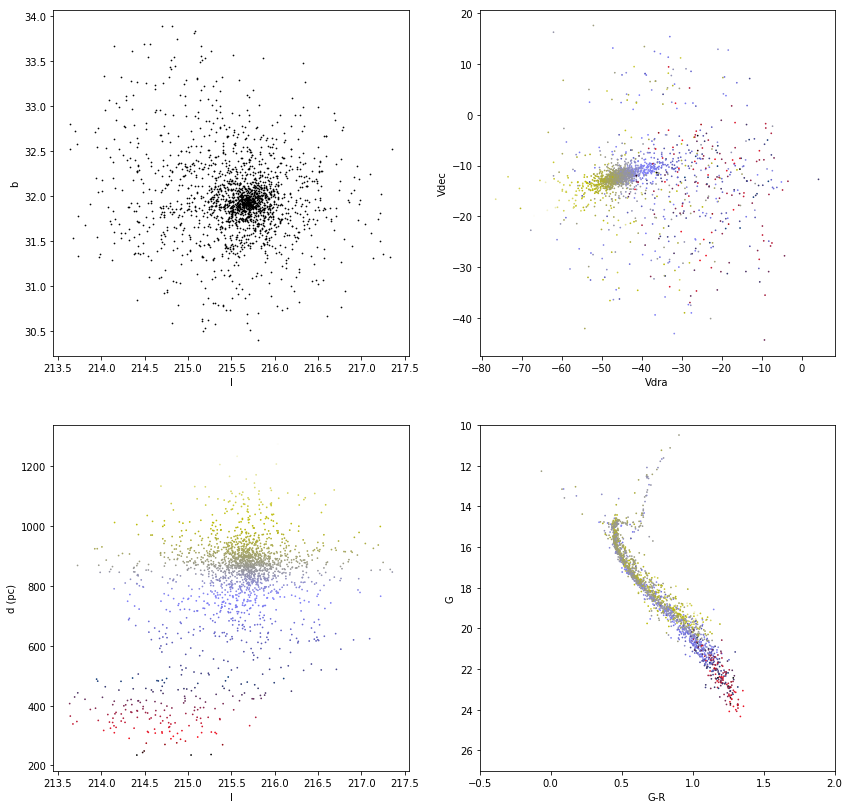

In [37]:
## plot the best solution...
print(ilab_)
print(cluster_['label'])
plot2d(source.df, labels_ , ilab, cmap = "gist_stern" ,color = False)

In [36]:
## separation distance
angl2pc = 3600. * 150e6 * distclust / 3.1e13
print("## Angular distance (1deg) : %3.1f pc"%(angl2pc))

## Angular distance (1deg) : 10.0 pc
